## Capstone Project 1 - In-Depth Analysis

This notebook contains the final stage of capstone 1 project's analyses. Since the outcome, popularity, is numerical, this would be a regression problem. We will try the following supervised learning methods on the data (supervised since the data is labeled):  
- LASSO
- Gradient Boosting  

To see the previous stages of work on this project, please refer to the following links: 
  
Data Wrangling: https://github.com/hamidniki/Capstone-project1/blob/master/Capstone%201%20Data%20Wrangling.ipynb 
  
Data Storytelling: https://github.com/hamidniki/Capstone-project1/blob/master/Capstone-Project1-Data-Storytelling.ipynb  
  
EDA: https://github.com/hamidniki/Capstone-project1/blob/master/Capstone-Project1-EDA.ipynb  

In [2]:
# Importing the relevant modules

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler

import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

from __future__ import division

### Reading in and Visually Inspecting the Dataset:

In [3]:
# Reading in the wrangled dataset from a CSV file 

filename = 'SpotifyAudioFeaturesNov2018_wrangled.csv'
data=pd.read_csv(filename)
data.head()

,Unnamed: 0,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,44
1,1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,10
2,2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,63
3,3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,9
4,4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,8


### Creating Dummy/Indicator Variables for Categorical Predictors (Key, Mode and Time Signature):

We treat Key, Mode and Time Signature as categorical variables since these variables do not have an ordinal nature and the difference between each 2 levels is only 1 unit. 

In [4]:
# Converting the categorial variables from int to string

data['key'] = data['key'].apply(str)
data['mode'] = data['mode'].apply(str)
data['time_signature'] = data['time_signature'].apply(str)

In [5]:
# Creating dummy variables
cats = data.loc[:,['key','mode','time_signature']]
cats = pd.get_dummies(cats)

data2 = pd.concat([data["acousticness"],
                   data["danceability"],
                   data["duration_ms"],
                   data["energy"],
                   data["instrumentalness"],
                   data["liveness"],
                   data["loudness"],
                   data["speechiness"],
                   data["tempo"],
                   data["valence"],
                   data["popularity"],
                   cats
                  ] , axis = 1)

#Dropping the first of the dummy variables to avoid duplicat info
#Note: Mode only has 2 levels, so we don't need to drop a level

data2 = data2.drop(['key_0','time_signature_0'],axis=1)

### Transforming the outcome variable:

The outcome variable, popularity, is not normal. This can cause issues in regression modeling.

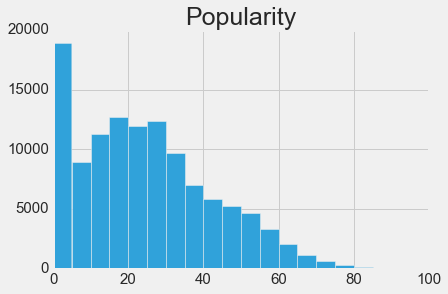

In [88]:
plt.style.use('fivethirtyeight')
plt.hist(data2['popularity'],bins=20)
plt.title("Popularity",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

We transform the outcome variable by taking squared root of it. Note that taking log would not be helpful since there are 0 values in popularity.

In [7]:
data2["pop_trans"] = map(lambda x: x**(0.5) , data2["popularity"]) 

#This could be done using np.sqrt() as well. I did it this way to practice using lambda functions.

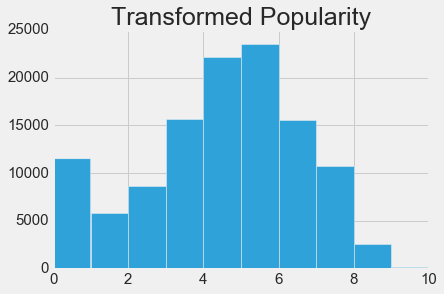

In [87]:
plt.hist(data2["pop_trans"])
plt.title("Transformed Popularity",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

The transformed popularity looks much more normal.

There are no missing values in the data. 

### LASSO Analyses:

In [36]:
# Defining predictor and target data frames

X = data2.drop(['popularity','pop_trans'],axis=1)
y = data2['pop_trans']

In [37]:
# 70-30 train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=21)

#### Hyperparameter Tunning:

In [39]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Since predictors have very different ranges, it is a good idea to standardize the predicotrs

# Steps for the pipeline
steps = [('scaler', StandardScaler()), ('lasso', Lasso())] 

# Instantiating the pipeline
pipeline = Pipeline(steps) 

# Range of alpha values to search 
parameters = {'lasso__alpha':np.array([1.01*10**((-1)*x) for x in range(1, 8)])}

# Grid search over alpha values with 5-fold CV for each alpha
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

# Fitting the model
cv.fit(X_train, y_train)
print(cv.best_params_)

{'lasso__alpha': 0.000101}


** Best alpha value picked = 0.000101 **

In [95]:
from sklearn.metrics import mean_squared_error

# Lasso on the entire train set with the best alpha value
lasso_best_alpha = Lasso(alpha=1.01e-4, normalize=True)

# Fit the model
lasso_best_alpha.fit(X_train, y_train)

#Predict on test
y_pred_lasso = lasso_best_alpha.predict(X_test)

print("R2 from train data: %.4f" % lasso_best_alpha.score(X_train, y_train))
print("R2 from test data: %.4f" % lasso_best_alpha.score(X_test, y_test))
print("MSE: %.4f" % mean_squared_error(y_test, y_pred_lasso))

R2 from train data: 0.0678
R2 from test data: 0.0678
MSE: 4.4904


These R2 values are not high. But the two values are close, meaning our model is generalizeable to unseen data.

#### Comparing Lasso Coefficients:

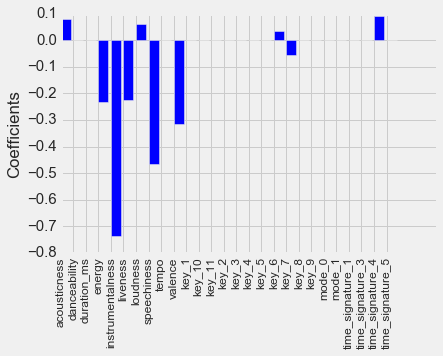

In [81]:
# Saving the coefficients
lasso_coef = lasso_best_alpha.fit(X_train, y_train).coef_

# Set the style
plt.style.use('fivethirtyeight')

#Plotting coefficients 
pred_names = X_train.columns

#Customizing the plot
plt.bar(range(len(pred_names)), lasso_coef, orientation = 'vertical')
plt.xticks(range(len(pred_names)), pred_names, rotation=90,fontsize=12)
plt.ylabel('Coefficients')
plt.yticks(fontsize=15)
plt.show()

** Observations on Coefficients:**
  
- Instrumentalness is negatively correlated with popularity. That is what we previously got in correlation plot
- Loudness is positively correlated with popularity. We also saw this in correlation plot.
- Time signature 4 is positively correlated with popularity (expected)

**Surprises: **
- Speechiness is showing as negatively correlated with popularity
- valence is showing as negatively correlated with popularity

#### Comparing Predicted vs Observed y:

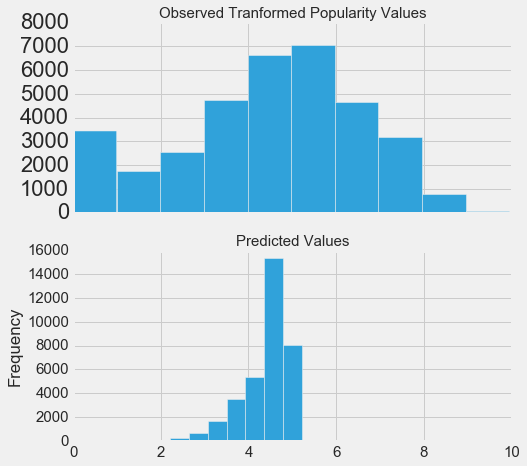

In [122]:
# Set the style
plt.style.use('fivethirtyeight')

f, axarr = plt.subplots(2, figsize=(7, 7),sharex=True)
axarr[0].hist(y_test)
axarr[0].set_title('Observed Tranformed Popularity Values',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Frequency")

axarr[1].hist(y_pred_lasso)
axarr[1].set_title('Predicted Values',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Gradient Boosting:

#### Establishing a baseline using default parameters:

In [96]:
#Import Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Instantiate a model with default parameters to establish a baseline
gbr = GradientBoostingRegressor(random_state = 42)

# Train the model on training data
gbr.fit(Xarr_train, yarr_train);

# Predict on test data
y_pred = gbr.predict(Xarr_test)

# Model Evaluation
print("Baseline model - R2 on train data: %.4f" % gbr.score(Xarr_train,yarr_train))
print("Baseline model - R2 on test data: %.4f" % gbr.score(Xarr_test,yarr_test))
print("Baseline model MSE: %.4f" % mean_squared_error(yarr_test, y_pred))

Baseline model - R2 on train data: 0.1351
Baseline model - R2 on test data: 0.1236
Baseline model MSE: 4.2214


** Observation: **  
This model is performing better than LASSO (where R2 was **~6.7%** and MSE was **4.49**) and the model seems to be generalizeable to unseen data since score from train and test data are close.

In [46]:
# Looking at the default parameters used by our baseline forest

from pprint import pprint
print('Parameters currently in use:\n')
pprint(gbr.get_params())

Parameters currently in use:

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}


#### Parameter Tunning Using Grid Search:

In [56]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'learning_rate': [0.1], # Trying learning rate values < 0.1 lowered the performance
    'max_features': ['sqrt','auto'],
    'n_estimators': [100], # 1000 using 1000 trees did not make much difference
    'min_samples_split': [2,10],#20,25],
    'min_samples_leaf': [1,2]#,5,10,20]
}

# Create a based model
gbr = GradientBoostingRegressor()

# Instantiate the grid search model
gbr_grid_search = GridSearchCV(estimator = gbr, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

In [57]:
# Fit the grid search to the data
gbr_grid_search.fit(Xarr_train, yarr_train)

# Optimal parameters
gbr_grid_search.best_params_

{'learning_rate': 0.1,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [97]:
# Predicting on test data using the best estimator
y_pred_gb = gbr_grid_search.best_estimator_.predict(Xarr_test)

# Model Evaluation
print("R2 on train data: %.4f" % gbr_grid_search.best_estimator_.score(Xarr_train,yarr_train))
print("R2 on test data: %.4f" % gbr_grid_search.best_estimator_.score(Xarr_test,yarr_test))
print("MSE: %.4f" % mean_squared_error(yarr_test, y_pred_gb))

R2 on train data: 0.1352
R2 on test data: 0.1235
MSE: 4.2221


**Observation:**  
This performance is very similar to that of the baseline model, indicating that the current performance is near optimal.

#### Variable Importances From Gradient Boosting Regression:

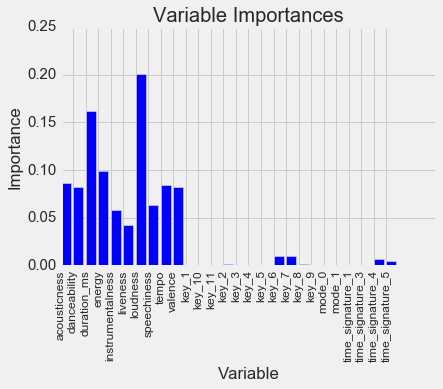

In [100]:
# Get numerical feature importances
importances = list(gbr_grid_search.best_estimator_.feature_importances_)

# feature names 
feature_list = list(X_train.columns)

# Plot feature importances

# Set the style
plt.style.use('fivethirtyeight')

x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical',fontsize=12)

# Axis labels and title
plt.ylabel('Importance');
plt.yticks(fontsize=15)
plt.xlabel('Variable'); 
plt.title('Variable Importances');
plt.show()

** Observations: **  
What we see in the plot above is in line with what we had seen in correlation plot in the storytelling notebook:   
https://github.com/hamidniki/Capstone-project1/blob/master/Capstone-Project1-Data-Storytelling.ipynb  

We also see that time_signature_4 is more popular than other time signatures, which is also expected from EDA done previously.

#### Comparing Predicted vs Observed y:

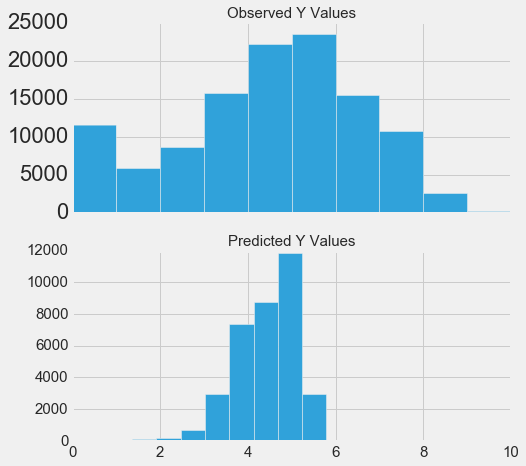

In [99]:
f, axarr = plt.subplots(2, figsize=(7, 7),sharex=True)
axarr[0].hist(data2.pop_trans)
axarr[0].set_title('Observed Y Values',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
f.subplots_adjust(wspace = 0.3)
axarr[1].hist(y_pred)
axarr[1].set_title('Predicted Y Values',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

This concludes the analysis of spotify audio features dataset.